# Report 3

### by Kaitlyn Keil and Kevin Zhang
### April 2017
#### Data Science Spring 2017

For reference on the database used: [UK Nutrient Database](http://tna.europarchive.org/20110116113217/http:/www.food.gov.uk/science/dietarysurveys/dietsurveys/)

To view variables and other user information about the database: [User Documentation](http://tna.europarchive.org/20110116113217/http://www.food.gov.uk/multimedia/pdfs/cofuserdoc.pdf)

This notebook is meant to assess the question of whether the Food Pyramid as prescribed by government and social standards is a useful tool in creating a balanced diet plan for oneself. This question stems from the controversy over whether the Food Pyramid is truly an accurate representation of food, and thus creating a divide between people who adhere to it as the food bible and others who go off on their own to find their own balanced diet.

The database used is the UK Nutrient database, which contains lots of information about nutrient composition of over 3000 common and popular foods throughout the UK. The granularity of the database makes it a very relevant and informative dataset for the purposes of answering the question.

To answer the question of whether the Food Pyramid is a "good" representation of food groups, we define "good" as being similar in its nutrient composition, specifically the macronutrients of Fats, Carbs, and Proteins. We choose this criteria because this is also how the Food Pyramid supposedly created its categories. We will use K-Means Clustering on the dataset of foods unsupervised using solely their nutrient compositions as criteria, and then compare the naturally clustered groups with the groups given by the Food Pyramid.

Overally, it appears that the Food Pyramid can be said to be outdated. Out of all foods evaluated, only about half were correctly categorized based on macronutrients. Most of the groups made by the Food Pyramid were scattered into several groups in the K-Means clusters. Perhaps the people who moved on to find their own balanced diet were on to something.

To view our code and a more detailed version of our work, continue reading.

To begin, we bring in all the imports.

In [1]:
from __future__ import print_function, division
import pandas as pd

import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
%matplotlib inline
import seaborn as sns

from collections import defaultdict, Counter
import statsmodels.formula.api as smf

from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


We then create a function to read in our dataset and clean it, pruning specifically the columns that we care about.

In [2]:
def ReadProximates():
    """ Reads the correct sheet from the Excel Spreadsheet downloaded from the databank.
    Cleans the macronutrient data and replaces non-numerical entries with 0.
    
    Returns: cleaned DataFrame
    """
    df = pd.read_excel('dietary.xls', sheetname='Proximates')
    column_list = ['Water (g)', 'Protein (g)', 'Fat (g)', 'Carbohydrate (g)', 'Total sugars (g)']
    
    df['Protein'] = pd.to_numeric(df['Protein (g)'], errors='coerce')
    df['Fat'] = pd.to_numeric(df['Fat (g)'], errors='coerce')
    df['Carbohydrate'] = pd.to_numeric(df['Carbohydrate (g)'], errors='coerce')
    df['Sugars'] = pd.to_numeric(df['Total sugars (g)'], errors='coerce')
    
    df['Protein'].replace([np.nan], 0, inplace=True)
    df['Fat'].replace([np.nan], 0, inplace=True)
    df['Carbohydrate'].replace([np.nan], 0, inplace=True)
    df['Sugars'].replace([np.nan], 0, inplace=True)
        
    return df

We then create our cleaned dataset.

In [3]:
tester = ReadProximates()

To get a sense of what we're dealing with, we directly plotted all foods on a log-log scale using a scatter plot, with the Carbs and Proteins as the axes and Fat as the radius of the dots. At first glance, it appears that the foods aren't particularly differentiated by nutrient content.

In [4]:
x_vals = 'Protein'
y_vals = 'Carbohydrate'
z_vals = 'Fat'

food_group_dict = {'A':['Cereals','peru'], 'B':['Dairy','beige'], 'C':['Egg','paleturquoise'],
                  'D':['Vegetable','darkolivegreen'], 'F':['Fruit','firebrick'], 'G':['Nuts','saddlebrown'],
                  'J':['Fish','slategray'],'M':['Meat','indianred'], 'O':['Fat','khaki']}

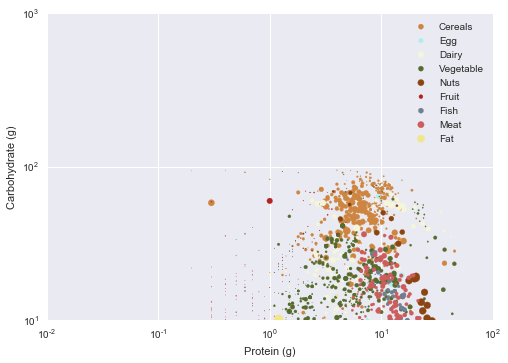

In [5]:
ax = plt.subplot(111)
for key,val in food_group_dict.items():
    df = tester[tester.Group.str.startswith(key, na=False)]
    ax.scatter(df[x_vals],df[y_vals],df[z_vals],color=val[1],label = val[0])
plt.xscale('log')
plt.yscale('log')
ax.set_xlabel(x_vals+' (g)')  
ax.set_ylabel(y_vals+' (g)')
ax.legend()

We created a function that could take in a category and plot a 3D scatter plot of the data, thus giving a modular function to use going into the rest of the code.

In [6]:
def ThreeDPlot(pred_cat, actual_cat, ax, actual_label, colors = ['firebrick', 'peru']):
    """ Creates a 3D log log plot on the requested subplot.
    Arguments: 
    pred_cat = predicted dataframe for a category
    actual_cat = dataframe of the real category
    ax = plt axis instance
    actual_label = string with label for the actual category
    colors = list with two entries of strings for color names
    """
    ax.scatter3D(np.log(pred_cat.Protein),np.log(pred_cat.Carbs), np.log(pred_cat.Fat), c = colors[0], label = 'Predicted Group')
    ax.scatter3D(np.log(actual_cat.Protein),np.log(actual_cat.Carbohydrate), np.log(actual_cat.Fat), c = colors[1], label = actual_label, alpha= .5)
    ax.view_init(elev=10, azim=45)
    
    ax.set_xlabel('Protein (log g)')
    ax.set_ylabel('Carbohydrate (log g)')
    ax.set_zlabel('Fat (log g)')
    plt.legend()

We now begin creating labels for the different food groups. Here we add a new column to hold the category given to the food by the Food Pyramid. We then create a new dataframe with only these categories for use in the rest of the code. The specific labels given are based on later knowledge of which K-Means groups matched the best with the Food Pyramid groups based on nutrient content.

In [7]:
cereals = tester[tester.Group.str.startswith('A', na=False)]
cereals['Label'] = cereals.Protein*0+2

fruits = tester[tester.Group.str.startswith('F', na=False)]
fruits['Label'] = fruits.Protein*0+3

veggies = tester[tester.Group.str.startswith('D', na=False)]
veggies['Label'] = veggies.Protein*0+1

dairy = tester[tester.Group.str.startswith('B', na=False)]
dairy['Label'] = dairy.Protein*0+5

oils = tester[tester.Group.str.startswith('O', na=False)]
oils['Label'] = oils.Protein*0+4

m1 = tester[tester.Group.str.startswith('J', na=False)]
m2 = tester[tester.Group.str.startswith('M', na=False)]
meats = pd.concat([m1,m2])
meats['Label'] = meats.Protein*0

all_these = pd.concat([cereals, fruits, veggies, dairy, oils, meats])


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

We now create a K-Means object and run it on the food data with only the macronutrients as criteria. We include sugar because we believe that sugar is also a very useful metric both in categorizing food and in helping people make decisions about diet.

In [8]:

# Selects the appropriate macronutrient columns to feed to the kmeans algorithm
protein = pd.Series(all_these.Protein, name='Protein')
fat = pd.Series(all_these.Fat, name='Fat')
carbs = pd.Series(all_these.Carbohydrate, name='Carbs')
sugars = pd.Series(all_these['Sugars'], name='Sugars')

# Create a new DataFrame using only the macronutrient columns
X = pd.concat([protein,fat,carbs,sugars], axis=1)
X.fillna(0)
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(X.dropna())
y_kmeans = kmeans.predict(X)

Below is the 3D scatter plot showing all the clusters from the K-Means algorithm.

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


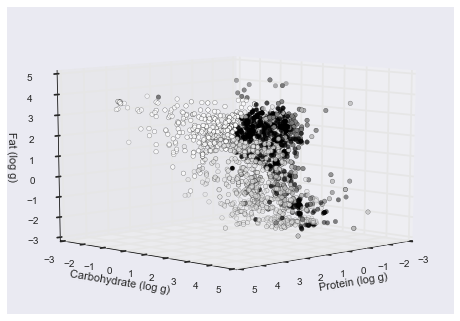

In [9]:
ax = plt.subplot(projection='3d')

ax.scatter3D(np.log(X.Protein),np.log(X.Carbs), np.log(X.Fat), c = y_kmeans)
ax.view_init(elev=10, azim=45)
    
ax.set_xlabel('Protein (log g)')
ax.set_ylabel('Carbohydrate (log g)')
ax.set_zlabel('Fat (log g)')

We now separate out different categories for analysis.

In [10]:
# Create a way to select the categories

predicted_labels = pd.DataFrame(y_kmeans, index=X.index).astype(float)
X['predictions'] = predicted_labels

In [11]:
# Separate out the categories for individual analysis

labeled0 = X[X.predictions == 0]
labeled1 = X[X.predictions == 1]
labeled2 = X[X.predictions == 2]
labeled3 = X[X.predictions == 3]
labeled4 = X[X.predictions == 4]
labeled5 = X[X.predictions == 5]

We the make another column that holds the correct guess for each food, in other words whether that food based on its K-Means group was placed in the same group as the one given to it from the Food Pyramid.

In [12]:
all_these['guess'] = predicted_labels[0]
all_these['correct_guess'] = np.where((all_these.Label == all_these.guess), True, False)

We took all the categories from K-Means and displayed each cluster's average nutrient content, which told us what group was most simiar to its corresponding one from the Food Pyramid.

In [13]:
all_these.groupby('guess').mean()

,Constant,Protein,Fat,Carbohydrate,Sugars,Label,correct_guess
guess,,,,,,,
0.0,8854.958785,21.264047,12.618945,1.659096,0.373950,0.340151,0.900969
1.0,11825.749049,3.268182,3.733617,7.092140,3.800379,1.861742,0.500947
2.0,6846.582192,10.049162,5.722346,64.426257,5.065363,2.005587,0.793296
3.0,9296.152542,6.644755,13.499301,59.844056,41.508392,2.636364,0.167832
4.0,6942.415094,2.796923,82.133846,0.655385,0.215385,3.076923,0.707692
5.0,12247.949602,6.333958,10.877917,25.503750,6.845417,1.668750,0.108333


Following are two examples, plotted on the 3d log scale. For the rest of the comparisons, see the bottom of the journal. This is a comparison of the two meat groups, one given by the Food Pyramid, and one proposed by the K-Means algorithm.

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log


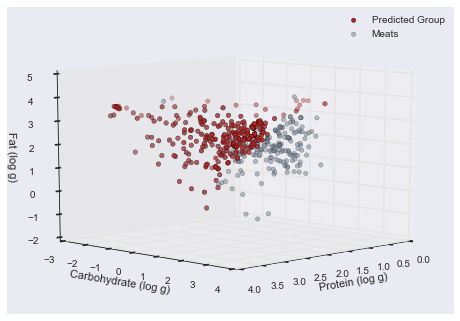

In [14]:
ax = plt.subplot(projection='3d')
ThreeDPlot(labeled0, meats, ax, 'Meats', ['firebrick','slategray'])

This one is the same as above, except it shows a comparison between the two for the fruit group.

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log


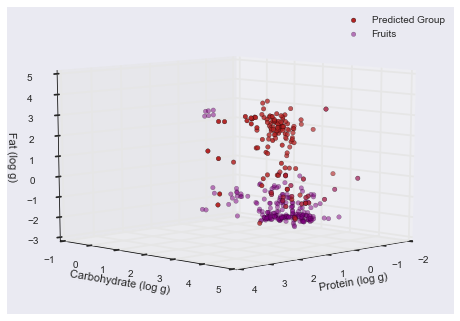

In [15]:
ax = plt.subplot(projection='3d')
ThreeDPlot(labeled3, fruits, ax, 'Fruits', ['firebrick','purple'])

We then generate an accuracy score using sklearn, which evaluates whether a particular food in K-Means was categorized in the same group as in the Food Pyramid across all foods. The result, 57% is barely above half.

In [16]:
accuracy_score(all_these.Label,predicted_labels)

0.57152875175315565

To gain a better understanding of what's happening, we decided to create a confusion matrix to view all the different individual accuracies between clusters. Below shows all of the clusters and where the foods ended up being grouped. Note that a perfect match would mean that the main diagonal of the matrix would be entirely black.

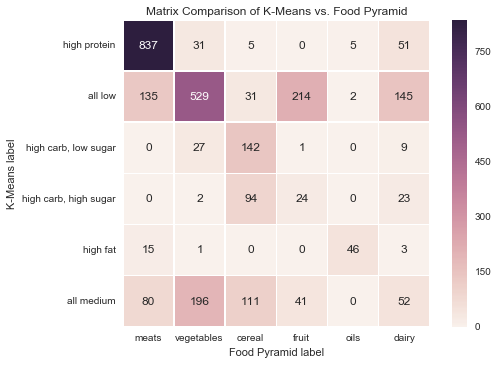

In [17]:
# Look at confusion matrix for some idea of accuracy. Meats has the highest rate of matching.

labels = ["meats", "vegetables", "cereal", "fruit", "oils", "dairy"]
predlabels = ["high protein", "all low", "high carb, low sugar", "high carb, high sugar", "high fat", "all medium"]
mat = confusion_matrix(all_these.Label, predicted_labels)
sns.heatmap(mat.T, square=True, xticklabels=labels, yticklabels=predlabels, annot=True, fmt="d", linewidth=.5)
plt.xlabel('Food Pyramid label')
plt.ylabel('K-Means label')
plt.title("Matrix Comparison of K-Means vs. Food Pyramid")

We then created another function that directly compares the most similar food groups between K-Means and the Food Pyramid. This modular function compares two labels against each other, and as stated above, the labels were created with later knowledge of the most similar groupings.

In [18]:
def HowMatched3D(df, label_int, actual_label):
    """ Creates a 3D log log plot on the requested subplot.
    Arguments: 
    pred_cat = predicted dataframe for a category
    actual_cat = dataframe of the real category
    ax = plt axis instance
    actual_label = string with label for the actual category
    colors = list with two entries of strings for color names
    """
    ax = plt.subplot(projection='3d')
    TP = df[(df.Label == label_int)&(df.correct_guess==True)]
    FP = df[(df.guess == label_int)&(df.correct_guess==False)]
    FN = df[(df.Label == label_int)&(df.correct_guess==False)]
    print('Matches:',len(TP), 'In Group, is not '+actual_label+':',len(FP), 'Not in Group, is '+actual_label+':',len(FN))
    ax.scatter3D(np.log(TP.Protein),np.log(TP.Carbohydrate), np.log(TP.Fat), c = '#8F008F', label = 'In Group, is '+actual_label)
    ax.scatter3D(np.log(FP.Protein),np.log(FP.Carbohydrate), np.log(FP.Fat), c = '#EB4C4C', label = 'In Group, is not '+actual_label)
    ax.scatter3D(np.log(FN.Protein),np.log(FN.Carbohydrate), np.log(FN.Fat), c = '#4CA6FF', label = 'Not in Group, is '+actual_label)
    ax.view_init(elev=10, azim=45)
    
    ax.set_xlabel('Protein (log g)')
    ax.set_ylabel('Carbohydrate (log g)')
    ax.set_zlabel('Fat (log g)')
    plt.legend()

Below are the 3D scatter plots on log-log-log scale for the 6 different food groups from the Food Pyramid with their most similar cluster from the K-Means algorithm. Note that while some are pretty coincident, others are completely off.

Matches: 837 In Group, is not Meat: 92 Not in Group, is Meat: 230


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log


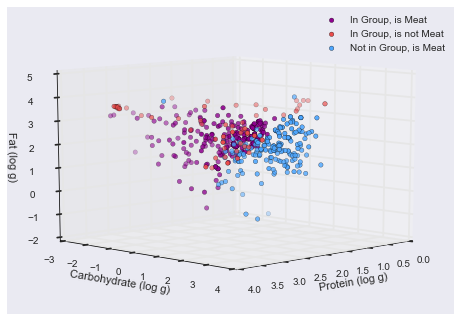

In [19]:
HowMatched3D(all_these, 0, 'Meat')

Matches: 529 In Group, is not Vegetable: 527 Not in Group, is Vegetable: 257


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log


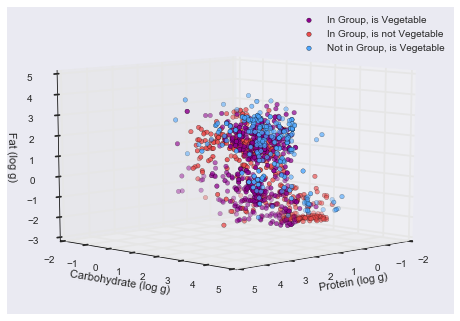

In [20]:
HowMatched3D(all_these, 1, 'Vegetable')

Matches: 142 In Group, is not Cereal: 37 Not in Group, is Cereal: 241


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log


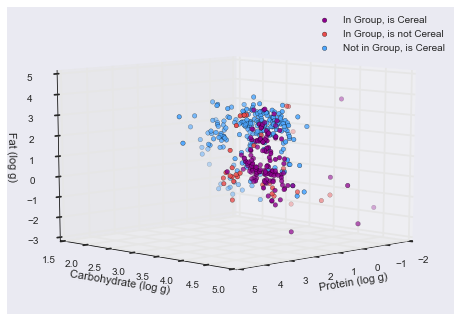

In [21]:
HowMatched3D(all_these, 2, 'Cereal')

Matches: 24 In Group, is not Fruit: 119 Not in Group, is Fruit: 256


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log


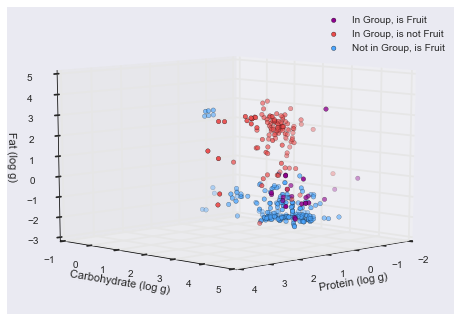

In [22]:
HowMatched3D(all_these, 3, 'Fruit')

Matches: 46 In Group, is not Oil: 19 Not in Group, is Oil: 7


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log


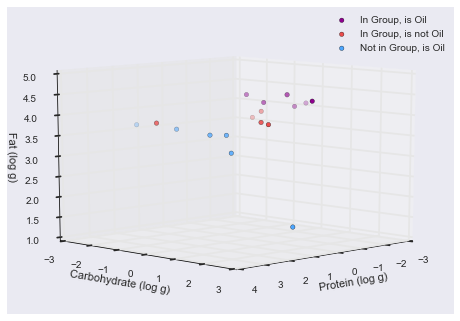

In [23]:
HowMatched3D(all_these, 4, 'Oil')

Matches: 52 In Group, is not Dairy: 428 Not in Group, is Dairy: 231


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log


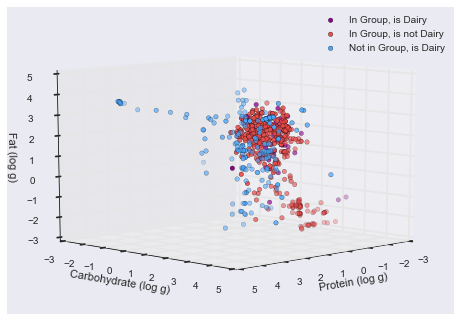

In [24]:
HowMatched3D(all_these, 5, 'Dairy')

We took the foods from the Food Pyramid and distributed them across the different clusters from K-Means, to really explicitly see which where the different foods lie. It would appear that the groupings from the Food Pyramid are completely scattered among the different clusters from K-Means, showing that their groupings are not particuarly in line with the foods' nutrient content.

In [25]:
df = pd.DataFrame(mat.T/mat.T.sum(axis=0),
             index=["high protein", "all low", "high carb, low sugar", "high carb, high sugar", "high fat", "all medium"],
             columns=["meats", "vegetables", "cereals", "fruits", "fats", "dairy"])
df.columns.name = 'Group Breakdown (percentages)'
df = df.round(2)
df = df.multiply(100)
df = df.astype(int).astype(str)
for index, row in df.iterrows():  
    for i in range(6):
        df.loc[index][i] = str(df.loc[index][i]) + "%"
df

Group Breakdown (percentages),meats,vegetables,cereals,fruits,fats,dairy
high protein,78%,4%,1%,0%,9%,18%
all low,13%,67%,8%,76%,4%,51%
"high carb, low sugar",0%,3%,37%,0%,0%,3%
"high carb, high sugar",0%,0%,25%,9%,0%,8%
high fat,1%,0%,0%,0%,87%,1%
all medium,7%,25%,28%,15%,0%,18%


Below are some examples of foods within the 6 groups made by the K-Means algorithm. We present to you, for fun, a small list of foods in each category, revealing some interesting wonders, as well as potentially some flaw in our design choices.

In [26]:
def Examples(df, label_int, si = [0,5]):
    """ Creates a 3D log log plot on the requested subplot.
    Arguments: 
    pred_cat = predicted dataframe for a category
    actual_cat = dataframe of the real category
    ax = plt axis instance
    actual_label = string with label for the actual category
    colors = list with two entries of strings for color names
    """
    TP = df[(df.Label == label_int)&(df.correct_guess==True)]
    FP = df[(df.guess == label_int)&(df.correct_guess==False)]
    print("Guessed Similar:")
    print(TP["Food Name"][si[0]:si[1]])
    print("\nSurprising:")
    print(FP["Food Name"][si[0]:si[1]])

The proposed Meat group, followed by the proposed Vegetable group.

In [27]:
print('High Protein Group')
Examples(all_these, 0)
print('\nLow Everything Group')
Examples(all_these, 1)

High Protein Group
Guessed Similar:
607    Shrimps, boiled
610    Lobster, boiled
611       Crab, boiled
612     Shrimps, dried
613    Shrimps, frozen
Name: Food Name, dtype: object

Surprising:
162    Cheese sandwich biscuits
165                Krackerwheat
347        Soya flour, full fat
348         Soya flour, low fat
361                   Wheatgerm
Name: Food Name, dtype: object

Low Everything Group
Guessed Similar:
2638    Pigeon peas, dahl, dried, boiled in unsalted w...
2641                          Pinto beans, re-fried beans
2642    Red kidney beans, dried, boiled in unsalted water
2647                                     Papri beans, raw
2649    Mung beans, whole, dried, boiled in unsalted w...
Name: Food Name, dtype: object

Surprising:
158                                Cornish wafers
163                                     Fig rolls
164                                Fruit biscuits
166    Oat based biscuits, chocolate, half coated
173             Shortcake, chocolate, hal

The proposed Cereal Group, followed by the proposed Fruits group.

In [28]:
print('High Carb, Low Sugar Group')
Examples(all_these, 2)
print('\nHigh Carb, High Sugar Group')
Examples(all_these, 3)

High Carb, Low Sugar Group
Guessed Similar:
141             Shortbread
143    Semi-sweet biscuits
145     Oatcakes, homemade
147       Oatcakes, retail
150     Wholemeal crackers
Name: Food Name, dtype: object

Surprising:
1034                           Tamarind
2637      Pigeon peas, dahl, dried, raw
2639            Pinto beans, dried, raw
2644    Lentils, red, split, dried, raw
2645       Red kidney beans, dried, raw
Name: Food Name, dtype: object

High Carb, High Sugar Group
Guessed Similar:
924    Grapefruit juice concentrate, unsweetened
925                      Grape juice concentrate
933                                 Pears, dried
960                             Pineapple, dried
972                                   Mixed peel
Name: Food Name, dtype: object

Surprising:
140    Biscuits, homemade, rubbing-in method
142            Crunch biscuits, cream filled
144          Sandwich biscuits, cream filled
146                     Short sweet biscuits
148                   Wafer bis

The proposed Fat group, followed by the proposed Dairy group.

In [29]:
print('High Fat Group')
Examples(all_these, 4)
print('\nMid Everything Group')
Examples(all_these, 5)

High Fat Group
Guessed Similar:
554                      Butteroil, unsalted
555                               Ghee, palm
556    Compound cooking fat, polyunsaturated
557                 Cocoa butter alternative
558                             Cocoa butter
Name: Food Name, dtype: object

Surprising:
3301                             Tomatoes, sun dried
2058                                   Cheese, cream
2107                           Cream, fresh, clotted
2111    Cream, fresh, double, including Jersey cream
700                                     Taramasalata
Name: Food Name, dtype: object

Mid Everything Group
Guessed Similar:
2115      Lollies, containing ice-cream
2116    Ice cream bar, chocolate coated
2117          Ice cream, dairy, premium
2118                      Sorbet, fruit
2119               Chocolate nut sundae
Name: Food Name, dtype: object

Surprising:
180    White bread, fried in lard
186               Wheatgerm bread
188      Wholemeal bread, average
195           Papp